In [29]:
# https://tyami.github.io/deep%20learning/GAN-3-implementation-DCGAN/
# 1. Load libraries
import numpy as np
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [30]:
# 결과 재현을 위해 random seed 설정
import random
manualSeed = 2020
# manualSeed = random.randint(1, 10000)
print("Random Seed:", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed);

Random Seed: 2020


In [31]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cpu


In [32]:
# 2. MNIST dataset download
image_size = 64 # 출력물 이미지 크기
batch_size = 64 # 배치 사이즈 설정

# standardizer : MNIST 전처리 모듈 정의 및 다운로드 수행 
standardizer = transforms.Compose([
                                    transforms.Resize(image_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=0.5,
                                                        std=0.5)])

# CIFAR_10 dataset
train_data = dsets.MNIST(root='../data/', train=True, transform=standardizer, download=True)

In [33]:
# Data loader
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)

FileNotFoundError: [Errno 2] No such file or directory: '../result/GAN/2-DCGAN/1-dataloader-example.png'

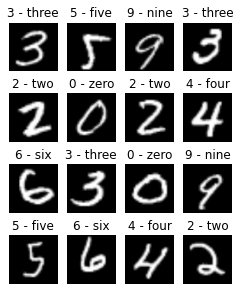

In [34]:
# function for visualization 
def tc_imshow(img, lbl=""):
    if img.size(0) == 1:
        plt.imshow(img.squeeze(), cmap='gray')
    else:
        plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(lbl)
    plt.axis('off')

# visualize
mini_batch_img, mini_batch_lbl = next(iter(train_data_loader))

plt.figure(figsize=(4,5))
for i in range(16): 
    plt.subplot(4,4,i+1)
    tc_imshow(img=mini_batch_img[i] / 2+0.5, 
             lbl=train_data.classes[mini_batch_lbl[i].numpy()])
    plt.axis('off')
plt.savefig('../result/GAN/2-DCGAN/1-dataloader-example.png', dpi=300)

In [35]:
# 3. Random sample z from uniform distribution
# hyper parameter
dim_noise = 100

def random_sample_z_space(batch_size=1, dim_noise=100):
    return torch.rand(batch_size, dim_noise, 1, 1, device=device)

z = random_sample_z_space(batch_size)

In [36]:
# 4. Generative model G
# hyper_parameters
dim_G_last2_channel = 64 # 최종 출력 이미지 직전 레이어의 채널 수
dim_output = mini_batch_img.size(1) # 최종 출력 이미지 채널 수

In [37]:
def initialize_weights(model): 
    class_names = model.__class__.__name__
    
    if class_names.find('Conv') != -1:
         nn.init.normal_(model.weight.data, 0.0, 0.02) # weight 평균 0, 표준편차 0.02 
        
    elif class_names.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [38]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
                    nn.ConvTranspose2d(in_channels=dim_noise,
                                       out_channels=dim_G_last2_channel*8,
                                       kernel_size=4,
                                       stride=1,
                                       padding=0,
                                       bias=False),
                    nn.BatchNorm2d(dim_G_last2_channel*8),
                    nn.ReLU(True),

                    nn.ConvTranspose2d(in_channels=dim_G_last2_channel*8,
                                       out_channels=dim_G_last2_channel*4,
                                       kernel_size=4, 
                                       stride=2,
                                       padding=1, 
                                       bias=False),
                    nn.BatchNorm2d(dim_G_last2_channel*4),
                    nn.ReLU(True),

                    nn.ConvTranspose2d(in_channels=dim_G_last2_channel*4,
                                       out_channels=dim_G_last2_channel*2,
                                       kernel_size=4, # 어떻게 정해진거지?
                                       stride=2,
                                       padding=1, # 어떻게 정해진거지?
                                       bias=False),
                    nn.BatchNorm2d(dim_G_last2_channel*2),
                    nn.ReLU(True),

                    nn.ConvTranspose2d(in_channels=dim_G_last2_channel*2,
                                       out_channels=dim_G_last2_channel,
                                       kernel_size=4, 
                                       stride=2,
                                       padding=1, 
                                       bias=False),
                    nn.BatchNorm2d(dim_G_last2_channel),
                    nn.ReLU(True),

                    nn.ConvTranspose2d(in_channels=dim_G_last2_channel,
                                       out_channels=dim_output,
                                       kernel_size=4, 
                                       stride=2,
                                       padding=1, 
                                       bias=False),
                    nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)

        return img

In [40]:
# visualize
G = Generator().to(device)
G.apply(initialize_weights)
utils.save_image(G(z)[:25].cpu().detach(), nrow=5, normalize=True)

TypeError: save_image() missing 1 required positional argument: 'fp'